## Excercise - GNSS data

**Task:** 
Visualize the GNSS data of ionospheric parameters

**Steps:**
- import libraries
- load data (.ismr format)
- process data
- plot data (keep in mind qualities of good data visualization)

**Bonus:**
- improve the vizualization of TEC variation
- plot the position of satelites to the sky projection (hint: use azimuth and elevation stored in columns 5 and 6)

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.dates as md
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
def gps2utc(gpsweek, gpsseconds, leapseconds=0):
    '''
    Calculates date and time for specified GPS week and GPS seconds.
    '''
    datetimeformat = "%Y-%m-%d %H:%M:%S"
    epoch = datetime.datetime.strptime("1980-01-06 00:00:00", datetimeformat)
    elapsed = datetime.timedelta(days=(gpsweek*7), seconds=(gpsseconds+leapseconds))
    return datetime.datetime.strftime(epoch + elapsed, datetimeformat)

In [3]:
## load data

# load data to Pandas Data Frame
# ismr data file contains 62 columns - see PolaRxS Application Manual 2.3.0.pdf

col_names = np.arange(1, 63).astype(str)
ismr_file = 'https://github.com/space-lab-sk/amon-es/raw/develop/data_samples/gnss_20200521-20141V.ismr'
ismrdf = pd.read_csv(ismr_file, names=col_names)
ismrdf = ismrdf.apply(pd.to_numeric, errors='coerce')   # convert all columns to numeric values
ismrdf.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0,2106,334860,1,628,161,46,45.5,0.108,0.053,0.025,0.035,0.047,0.049,0.050,-3.751,0.151,19.517,0.017,17.194,0.011,15.014,0.013,16.861,0.020,15873.0,752,15852.0,47.1,0.022,2.334,1.76,44.4,0.120,0.061,0.024,0.032,0.041,0.042,0.042,-3.813,0.160,15605.0,0.027,2.514,1.71,49.8,0.032,0.032,0.017,0.026,0.035,0.036,0.037,-3.442,0.029,15945.0,0.008,0.842,1.86,0.000079,0.000088,0.000044
1,2106,334860,3,628,18,82,49.1,0.036,0.035,0.019,0.027,0.033,0.034,0.034,-7.192,0.082,7.705,0.004,9.285,0.003,8.190,0.006,10.113,-0.011,11860.0,752,11832.0,52.7,0.009,0.997,1.88,47.6,0.039,0.042,0.019,0.025,0.029,0.030,0.031,-10.674,0.085,11851.0,0.011,1.080,1.77,52.5,0.023,0.024,0.015,0.020,0.024,0.025,0.025,-13.168,0.024,11863.0,0.006,0.651,1.89,0.000053,0.000051,0.000029
2,2106,334860,4,628,217,53,46.6,0.049,0.047,0.017,0.024,0.030,0.032,0.033,-7.234,0.085,15.474,-0.030,12.742,-0.035,12.799,-0.012,13.208,-0.029,5750.0,752,5733.0,35.9,0.012,1.323,1.67,45.5,0.050,0.053,0.018,0.025,0.028,0.030,0.030,-8.591,0.126,5742.0,0.014,1.347,1.66,49.5,0.035,0.033,0.013,0.018,0.023,0.024,0.024,-11.890,0.062,5750.0,0.008,0.888,1.61,0.000039,0.000049,0.000019
3,2106,334860,6,628,317,10,39.9,0.103,0.102,0.034,0.040,0.045,0.046,0.046,0.623,0.212,25.092,-0.028,18.980,-0.067,21.589,-0.061,18.400,-0.036,682.0,752,653.0,23.2,0.031,2.869,1.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000151,NaN,NaN
4,2106,334860,9,628,227,18,40.9,0.165,0.091,0.036,0.043,0.047,0.048,0.048,-1.909,0.168,19.303,-0.039,21.369,-0.039,19.741,-0.045,19.655,-0.068,677.0,752,671.0,36.6,0.044,4.114,1.77,38.7,0.170,0.116,0.040,0.047,0.050,0.051,0.051,-1.029,0.252,230.0,0.056,4.471,1.60,41.7,0.098,0.082,0.030,0.036,0.039,0.040,0.040,-2.147,0.154,506.0,0.028,2.564,1.67,0.000191,0.000228,0.000135


In [4]:
## process data

# calculate the date
ismrdf['datetime'] = ismrdf.apply(lambda x: gps2utc(x['1'], x['2']), axis=1)
ismrdf = ismrdf.set_index('datetime')
ismrdf.index = pd.to_datetime(ismrdf.index)

# select unique numbers of satellites in data frame
satsu = ismrdf['3'].unique()
sats = np.sort(satsu)
# select numbers of GPS satellites
sgps = [i for i in sats if i <= 37]
# select numbers of Galileo satellites
sgal = [i for i in sats if 71 <= i <= 106]
print(sats)
print(sgps)
print(sgal)

[  1   2   3   4   6   9  11  14  17  19  22  25  26  31  39  40  41  48
  49  50  54  55  56  57  72  73  75  77  78  83  84  85  94  95  96 123
 125 126 127 128 136 140]
[1, 2, 3, 4, 6, 9, 11, 14, 17, 19, 22, 25, 26, 31]
[72, 73, 75, 77, 78, 83, 84, 85, 94, 95, 96]


In [5]:
## process data

# select just TEC (Total Electron Content) values for each satellite
# index needs to be set to keep equal number of rows for each DF
tecdf = pd.DataFrame(index=ismrdf.index.unique())      # TEC data frame

# for all GPS satellites
for i in range(0, len(sgps)):
    iidf = ismrdf[ismrdf['3'] == sgps[i]]
    tecdf['G' + str(sgps[i])] = iidf['23']     # TEC at time t is in the column '23'
# for all European Galileo satellites
for i in range(0, len(sgal)):
    iidf = ismrdf[ismrdf['3'] == sgal[i]]
    tecdf['E' + str(sgal[i]-70)] = iidf['23'] 

tecdf.head()

,G1,G2,G3,G4,G6,G9,G11,G14,G17,G19,G22,G25,G26,G31,E2,E3,E5,E7,E8,E13,E14,E15,E24,E25,E26
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-20 21:01:00,16.861,NaN,10.113,13.208,18.400,19.655,20.630,6.990,12.355,8.625,6.339,NaN,NaN,12.075,NaN,10.031,20.071,29.135,8.535,8.140,22.333,17.035,19.830,22.289,18.847
2020-05-20 21:02:00,15.347,NaN,8.067,11.780,16.724,15.286,32.625,8.408,19.124,8.282,9.690,NaN,NaN,18.206,NaN,10.590,12.548,24.547,9.560,9.491,24.445,16.616,17.299,21.730,14.383
2020-05-20 21:03:00,16.851,NaN,7.753,11.571,15.239,24.329,25.504,9.836,16.296,9.996,12.146,NaN,NaN,15.988,NaN,11.498,13.223,19.819,8.427,9.366,27.457,17.275,13.238,24.338,14.080
2020-05-20 21:04:00,16.832,NaN,8.571,10.590,18.181,18.627,27.037,14.329,5.796,6.312,10.385,NaN,NaN,14.674,NaN,9.930,14.248,17.684,8.776,11.680,30.050,17.229,17.741,20.022,16.417
2020-05-20 21:05:00,15.442,NaN,7.952,9.648,26.120,20.559,25.381,11.578,11.803,2.513,10.423,NaN,NaN,14.455,NaN,9.410,20.118,18.049,8.923,9.102,29.755,17.532,17.570,25.642,15.601


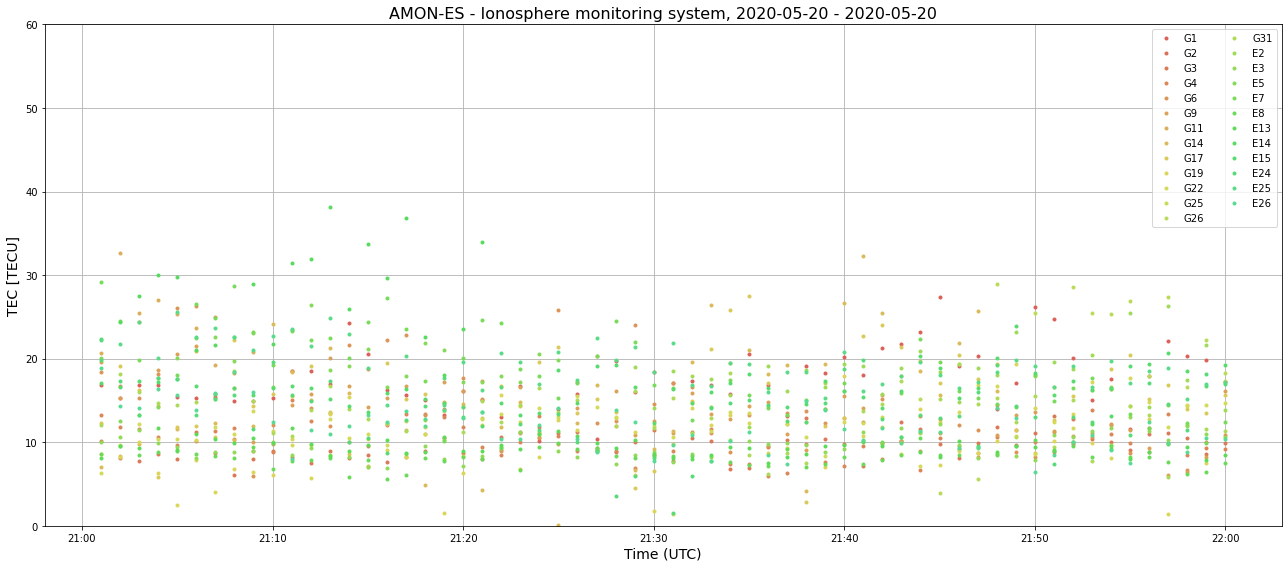

In [6]:
## plot data

scol = list(tecdf)  # list of used satellites
sns.set_palette(sns.color_palette("hls", 60))
plt.figure(figsize=(18, 8))
plt.title('AMON-ES - Ionosphere monitoring system, ' + str(tecdf.index[0])[:10] + ' - ' + str(tecdf.index[-1])[:10], fontsize=16)
plt.xlabel('Time (UTC)', fontsize=14)
plt.ylabel('TEC [TECU]', fontsize=14)
plt.ylim(0, 60)
plt.grid()
ax = plt.gca()
my_dt = '%H:%M'
xfmt = md.DateFormatter(my_dt)
ax.xaxis.set_major_formatter(xfmt)
for item in scol:
    plt.plot(tecdf.index, tecdf[item], '.', label=item)
plt.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()

In [7]:
## BONUS:

# write your code here